# **Portfolio Duration**


### **1. Download Data**

Download historical Treasury yields from Yahoo Finance for the tickers and range below.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

TICKERS = {"3M": "^IRX", "5Y": "^FVX", "10Y": "^TNX", "30Y": "^TYX"}
START = "2010-01-01"

raw = yf.download(list(TICKERS.values()),
                  start=START, progress=False,
                  group_by="ticker", auto_adjust=False, actions=False)

adj = raw.loc[:, (slice(None), "Adj Close")]
adj.columns = [t for (t, _) in adj.columns]

# Rename tickers, convert "percent × 10" to decimals
yields = adj.rename(columns={v: k for k, v in TICKERS.items()}).mul(0.001).dropna()
yields.index.name = "Date"
display(yields)

,3M,10Y,30Y,5Y
Date,,,,
2010-01-04,0.000055,0.003841,0.004660,0.002652
2010-01-05,0.000060,0.003755,0.004593,0.002558
2010-01-06,0.000045,0.003808,0.004671,0.002573
2010-01-07,0.000045,0.003822,0.004689,0.002600
2010-01-08,0.000040,0.003808,0.004695,0.002566
...,...,...,...,...
2025-11-07,0.003757,0.004093,0.004700,0.003680
2025-11-10,0.003783,0.004110,0.004702,0.003710
2025-11-11,0.003783,0.004120,0.004710,0.003719


### **2. Plot the raw yields (3M, 5Y, 10Y, 30Y) since 2010**.

Identify major trends/regimes.

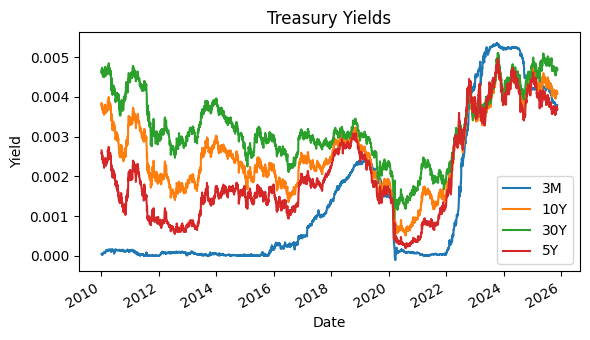

In [2]:
import matplotlib.pyplot as plt

ax = yields.plot(figsize=(6, 3.5), title="Treasury Yields")
ax.set_xlabel("Date")
ax.set_ylabel("Yield")
plt.tight_layout()
plt.show()

### **3. Define three bonds**

Define three bonds (assume annual coupons) and store them in a dict:

In [3]:
bonds = {
    "10Y Treasury": {"maturity": 10, "face": 1000, "coupon_rate": 0.03,  "price": 950, "freq": 1},
    "20Y Treasury": {"maturity": 20, "face": 1000, "coupon_rate": 0.035, "price": 980, "freq": 1},
    "30Y Treasury": {"maturity": 30, "face": 1000, "coupon_rate": 0.04,  "price": 1020,"freq": 1},
}

### **4. Pricing function**
 Implement price_bond(bond, ytm) that discounts each cash flow at the annual effective rate ytm.

In [4]:
def price_bond(bond, ytm):
    m = bond.get("freq", 1)
    n = int(round(bond["maturity"] * m)) # total coupons
    face = bond["face"]
    cpn  = face * bond["coupon_rate"] / m

    times = np.arange(1, n + 1) / m # years to each cash flow
    cash  = np.full(n, cpn, dtype=float)
    cash[-1] += face # add face
    disc = (1 + ytm) ** times # annual effective discounting
    return float(np.sum(cash / disc))

In [5]:
bond = {"maturity": 10, "face": 1000, "coupon_rate": 0.03, "freq": 1}
print(price_bond(bond, ytm=0.032))  # annual effective 3.2%

983.1124126241435


### **5. Macaulay duration**

 Write a function that computes Macaulay duration from cash flows and discount factors.

Check: For a zero-coupon bond, Macaulay duration equals time to maturity.

In [6]:
def macaulay_duration_bond(bond, ytm):

    m = bond.get("freq", 1)
    n = int(round(bond["maturity"] * m))
    face = bond["face"]
    cpn  = face * bond["coupon_rate"] / m

    times = np.arange(1, n + 1) / m  # years
    cash  = np.full(n, cpn, dtype=float)
    cash[-1] += face # add face

    disc = (1 + ytm) ** times # annual-effective
    pv   = cash / disc
    P    = pv.sum()
    return float(np.sum(times * pv) / P)

Quick check (zero-coupon):

In [7]:
z = {"maturity": 5, "face": 1000, "coupon_rate": 0.0, "freq": 1}
print(macaulay_duration_bond(z, ytm=0.04))  # = 5.0 years

5.0


### **6. Convexity**

Implement convexity for a coupon bond.

Explain: Convexity adjusts the duration-based linear approximation to better capture curvature of price-yield for larger moves.

In [8]:
def convexity_bond(bond, ytm):
    m = bond.get("freq", 1)
    n = int(round(bond["maturity"] * m))
    face = bond["face"]
    cpn  = face * bond["coupon_rate"] / m

    times = np.arange(1, n + 1) / m # in years
    cash  = np.full(n, cpn, dtype=float)
    cash[-1] += face # add face

    disc = (1 + ytm) ** times
    P = float(np.sum(cash / disc))

    # C = (1/P) * Σ [ CF_t * t*(t+1) / (1+ytm)^(t+2) ]
    C = float(np.sum(cash * times * (times + 1) / (1 + ytm) ** (times + 2)) / P)
    return C

### **7. Shock test (±100 bps)**
Compare 
- Duration-only estimate
- Duration+convexity estimate
Summarize the errors for all three bonds.

What to do (per bond):

- Get a working ytm (use the bond’s stated price to solve an implied ytm).
- Compute P0, Modified duration, Convexity at that ytm.
- Reprice exactly at ytm ± 0.01.
- Build duration-only and duration+convexity estimates.
- Report absolute errors vs. exact.

In [9]:
# Select yield and compute metrics 
ytm = 0.04   # 4% annual
P0  = price_bond(bond, ytm)
Dmac = macaulay_duration_bond(bond, ytm)
Dmod = Dmac / (1 + ytm)
Cvx  = convexity_bond(bond, ytm)

print(f"Price at 4% yield: {P0:.2f}")
print(f"Macaulay duration: {Dmac:.3f} years")
print(f"Modified duration: {Dmod:.3f}")
print(f"Convexity: {Cvx:.3f}")

# ---Compare price changes for + or - 100 bps
dy = 0.01  # 100 basis points
P_up = price_bond(bond, ytm + dy)
P_dn = price_bond(bond, ytm - dy)

# Duration-only and duration+convexity estimates
P_up_dur  = P0 * (1 - Dmod * dy)
P_up_dc   = P0 * (1 - Dmod * dy + 0.5 * Cvx * dy**2)
P_dn_dur  = P0 * (1 + Dmod * dy)
P_dn_dc   = P0 * (1 + Dmod * dy + 0.5 * Cvx * dy**2)

print("\nYield +100 bps:")
print(f"  Exact: {P_up:.2f}, Dur-only est: {P_up_dur:.2f}, Dur+Convexity est: {P_up_dc:.2f}")

print("Yield -100 bps:")
print(f"  Exact: {P_dn:.2f}, Dur-only est: {P_dn_dur:.2f}, Dur+Convexity est: {P_dn_dc:.2f}")

Price at 4% yield: 918.89
Macaulay duration: 8.723 years
Modified duration: 8.387
Convexity: 84.604

Yield +100 bps:
  Exact: 845.57, Dur-only est: 841.82, Dur+Convexity est: 845.71
Yield -100 bps:
  Exact: 1000.00, Dur-only est: 995.96, Dur+Convexity est: 999.85
